# XG Boosted Trees for joint pain prediction

In [1]:
import numpy as np
import pandas as pd
import os
from scipy import stats
from statsmodels.tsa import stattools
from sklearn import preprocessing
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
feats = np.load('jointProblem_feats_15_aligned.npy')
labels = np.load('../processed_datasets/jointProblem_y_15_aligned.npy')
ids = np.load('../processed_datasets/jointProblem_ids_15_aligned.npy')
feats.shape, labels.shape, ids.shape

((863004, 14, 15), (863004,), (863004,))

In [ ]:
#Optional, select only accel and gyro
feats = feats[:, :, [0, 1, 2, 4, 5, 6]]
feats.shape

In [3]:
# Using Scikit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

#Flatten the features
feats = feats.reshape((feats.shape[0], -1))

#Remove nans
valid_idxs = ~np.isnan(feats).any(axis=1)
feats = feats[valid_idxs]
labels = labels[valid_idxs]
ids = ids[valid_idxs]

print(feats.shape, labels.shape)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels, train_ids, test_ids = train_test_split(feats, labels, ids, test_size = 0.1, random_state = 42, shuffle = False)
train_features, val_features, train_labels, val_labels, train_ids, val_ids = train_test_split(train_features, train_labels, train_ids, test_size = 2/9, random_state = 42, shuffle = False)
#Scale the features
train_features_scaled = preprocessing.scale(train_features)
test_features_scaled = preprocessing.scale(test_features)
val_features_scaled = preprocessing.scale(val_features)


print('Training Features Shape:', train_features_scaled.shape)
print('Training Labels Shape:', train_labels.shape)
print('Val Features Shape:', val_features_scaled.shape)
print('Val Labels Shape:', val_labels.shape)
print('Testing Features Shape:', test_features_scaled.shape)
print('Testing Labels Shape:', test_labels.shape)

(859883, 210) (859883,)
Training Features Shape: (601917, 210)
Training Labels Shape: (601917,)
Val Features Shape: (171977, 210)
Val Labels Shape: (171977,)
Testing Features Shape: (85989, 210)
Testing Labels Shape: (85989,)


In [4]:
#Optional, balance the dataset
false_idx = np.nonzero(train_labels == False)[0]
true_idx = np.nonzero(train_labels)[0]
print(len(false_idx), len(true_idx))
num_to_take = min(len(false_idx), len(true_idx))

valid_idx = np.concatenate((false_idx[:num_to_take], true_idx[:num_to_take]))
np.random.shuffle(valid_idx)

train_features_scaled = train_features_scaled[valid_idx]
train_labels = train_labels[valid_idx]
train_ids = train_ids[valid_idx]
print(train_ids.shape)

502514 99403
(198806,)


In [5]:
# The baseline predictions are the train set averages
baseline_preds = np.zeros_like(train_labels) + np.mean(train_labels)
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - train_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.5


In [6]:
# Import the model we are using
from xgboost import XGBRegressor
# Instantiate model
model = XGBRegressor(n_estimators=100, objective='binary:logistic', gamma=0, reg_alpha=0, reg_lambda=1, tree_method='gpu_exact')
model.fit(train_features_scaled, train_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, tree_method='gpu_exact',
             verbosity=1)

In [7]:
# Use the model's predict method on the train data
predictions = model.predict(train_features_scaled)
acc = np.round(predictions) == train_labels
print('Train Accuracy:', np.mean(acc))

Train Accuracy: 0.6888021488285062


Text(0.5, 1, 'Joint Problem Prediction Confusion Matrix')

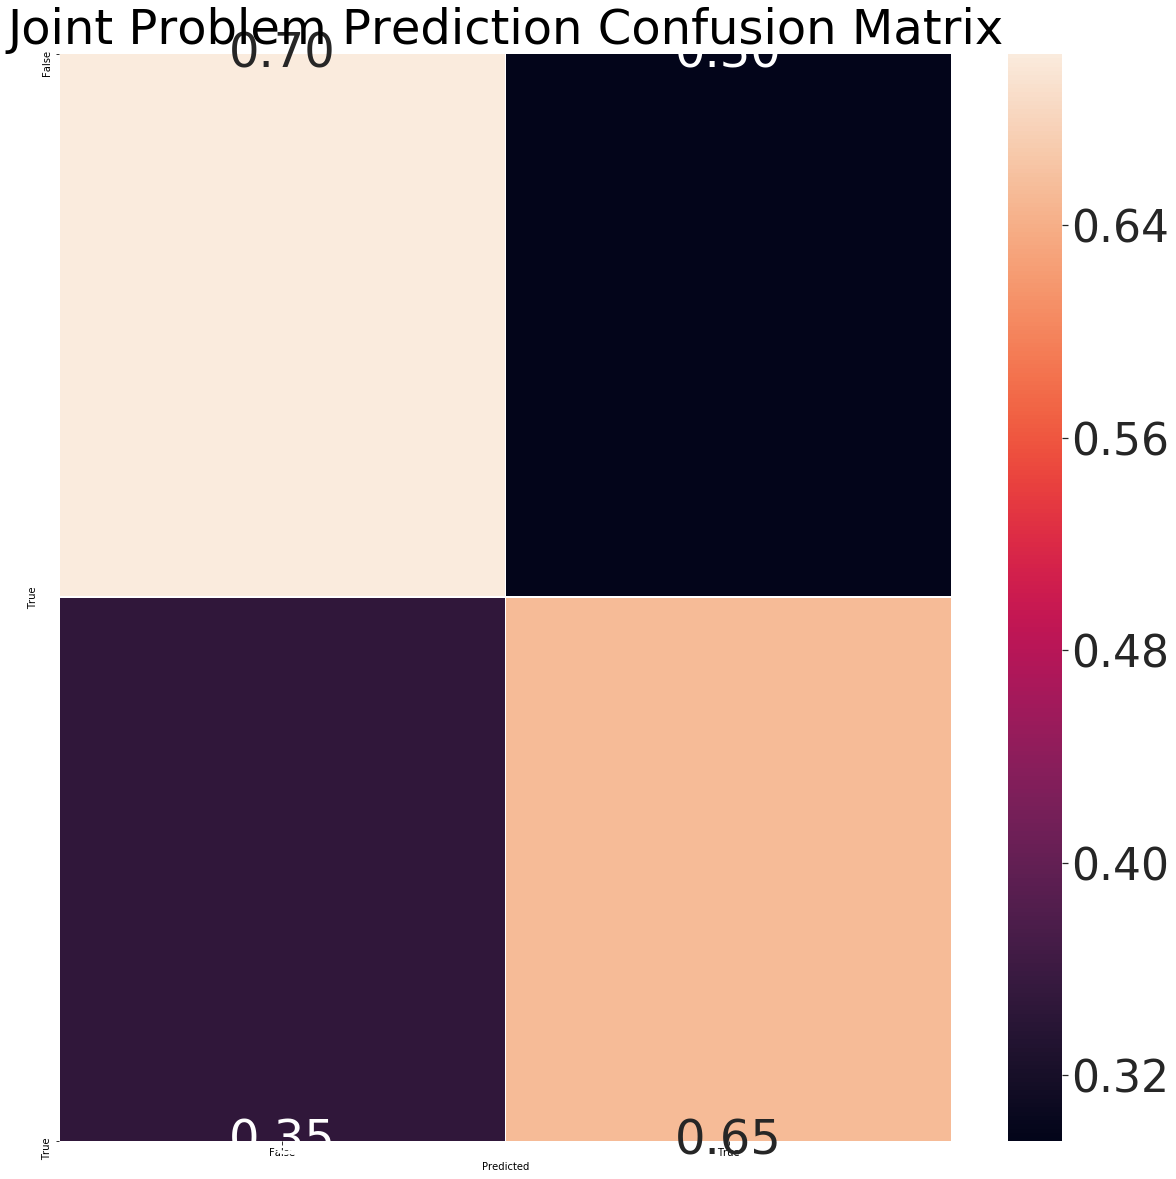

In [9]:
#Print confusion matrix
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((train_labels,predictions.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['False', 'True'],
            yticklabels = ['False', 'True'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Joint Problem Prediction Confusion Matrix')

In [8]:
# Use the model's predict method on the val data
predictions = model.predict(test_features_scaled)
acc = np.round(predictions) == test_labels
print('Test Accuracy:', np.mean(acc))

Test Accuracy: 0.6696321622533115


Text(0.5, 1, 'Gender Prediction Confusion Matrix')

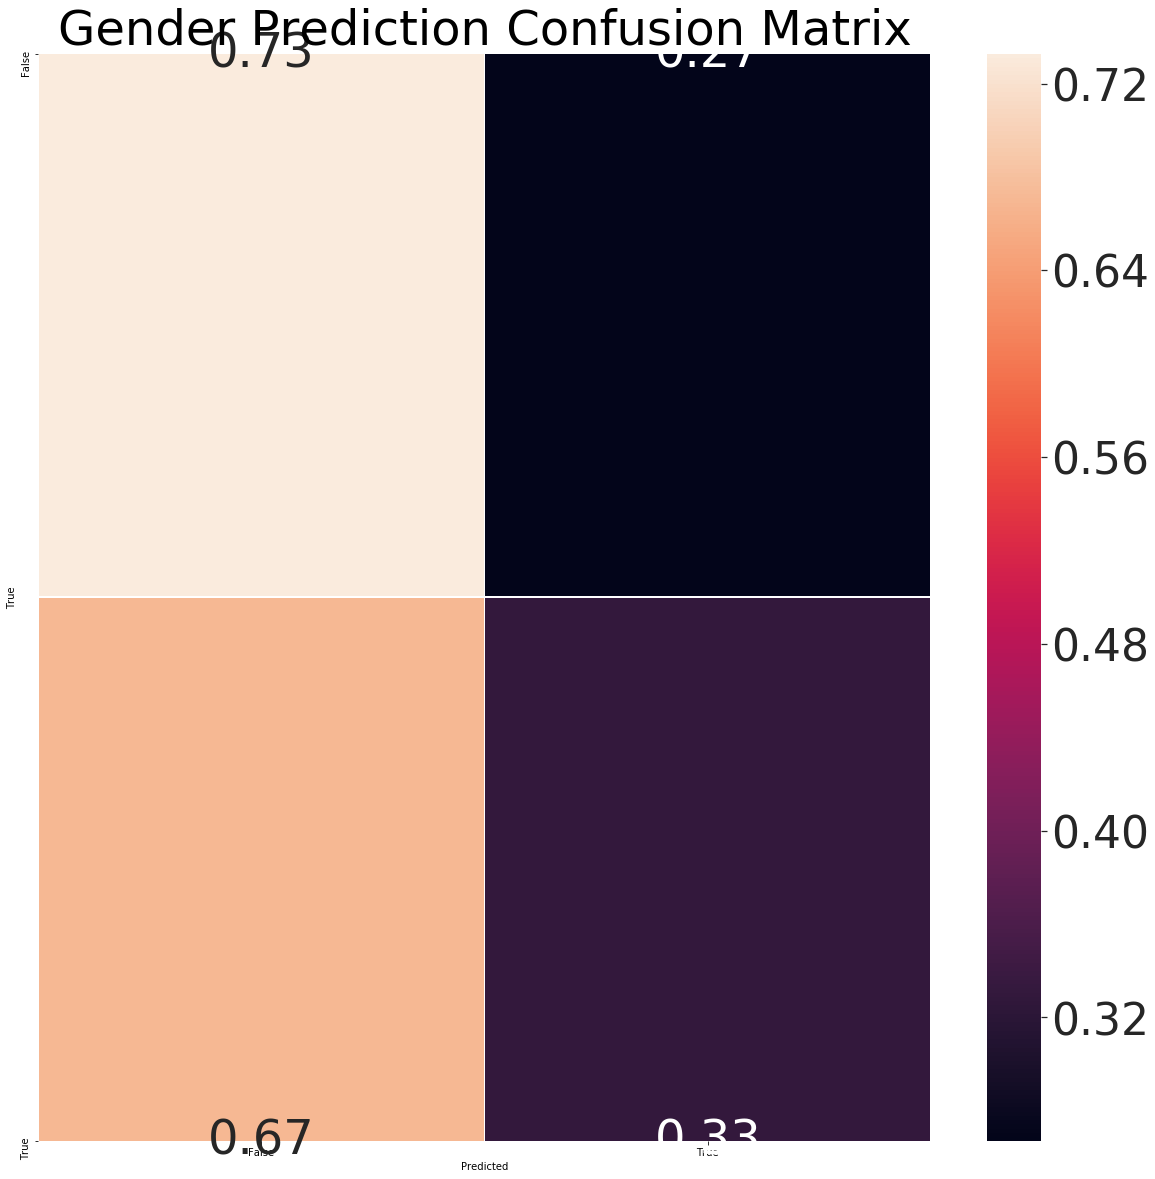

In [9]:
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((test_labels,predictions.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['False', 'True'],
            yticklabels = ['False', 'True'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

In [10]:
feature_list = np.arange(210)
# Get numerical feature importances
importances = list(model.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 10)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable:                   16 Importance: 0.04157601669430733
Variable:                  136 Importance: 0.03511491417884827
Variable:                  183 Importance: 0.03466564416885376
Variable:                   94 Importance: 0.03024335950613022
Variable:                  179 Importance: 0.02956889197230339
Variable:                   55 Importance: 0.026108577847480774
Variable:                   66 Importance: 0.02328949235379696
Variable:                   19 Importance: 0.02273109368979931
Variable:                  152 Importance: 0.021436698734760284
Variable:                   74 Importance: 0.019990386441349983
Variable:                  181 Importance: 0.01733410358428955
Variable:                   65 Importance: 0.01689952053129673
Variable:                   72 Importance: 0.015353351831436157
Variable:                  155 Importance: 0.014809561893343925
Variable:                  171 Importance: 0.01434492040425539
Variable:                   14 Importance: 0.01384

AUROC: 0.5302930884331953


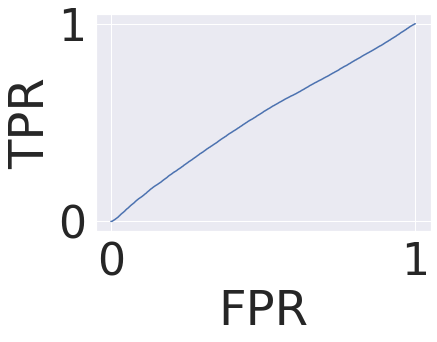

EER Threshold: 0.45813322 EER:  0.4733520529655476


Text(0.5, 1, 'Gender Prediction Confusion Matrix')

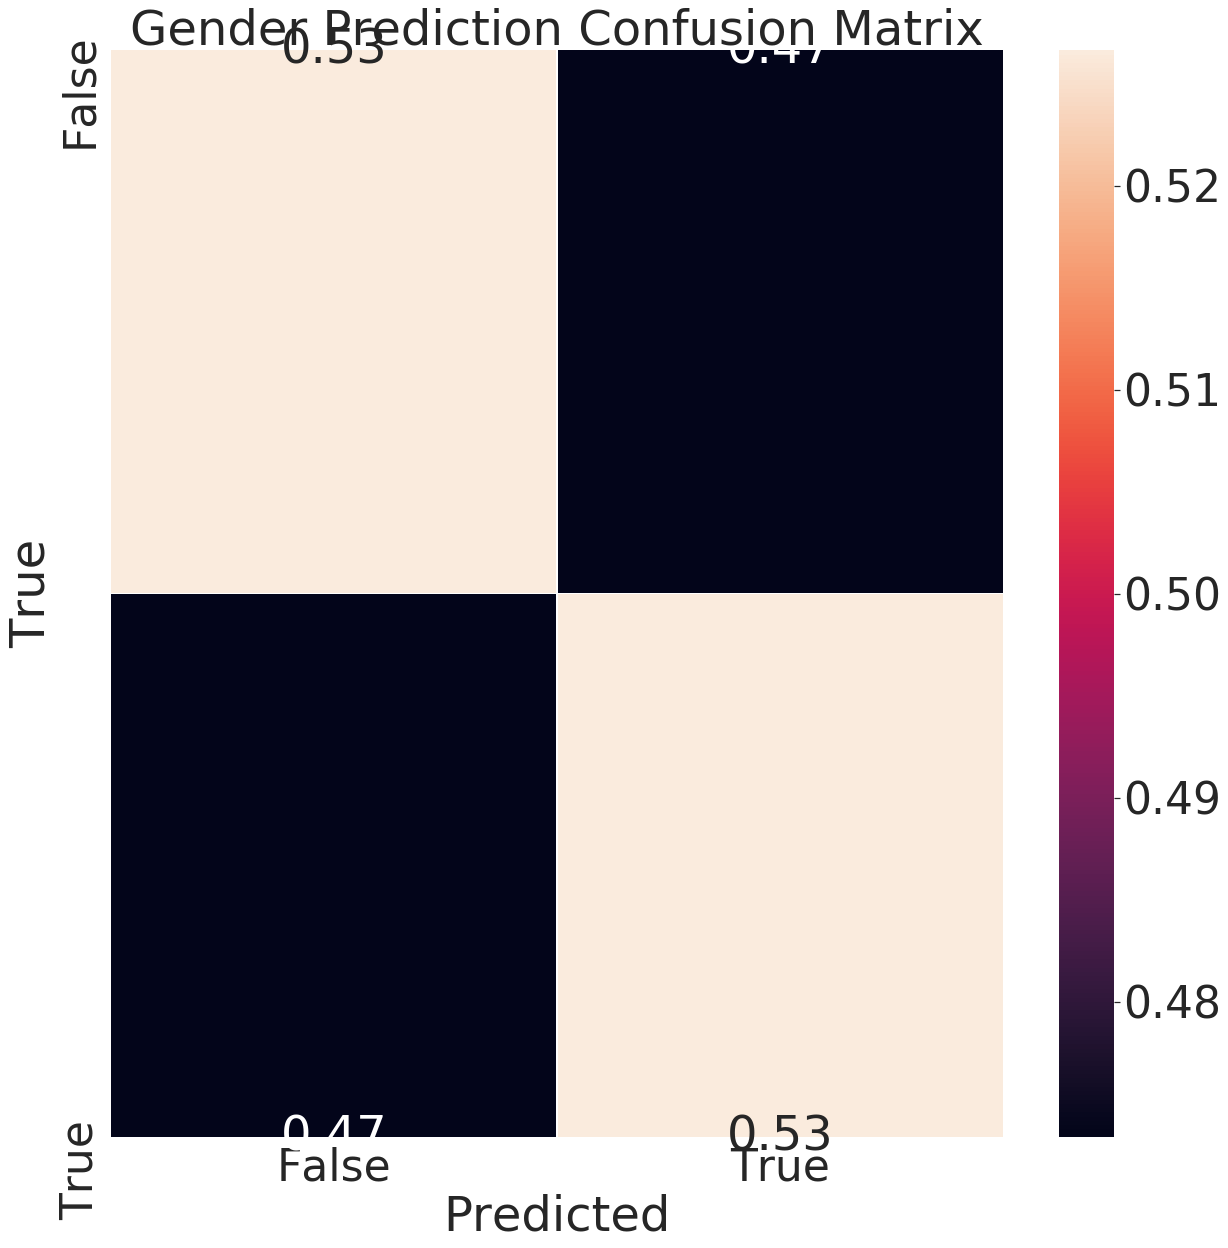

In [11]:
#ROC curve
from sklearn import metrics
y_score = model.predict(val_features_scaled)
fpr, tpr, threshs = metrics.roc_curve(val_labels, y_score)

print("AUROC: {}".format(metrics.roc_auc_score(val_labels, y_score)))

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

fnr = 1 - tpr
eer_threshold = threshs[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
print("EER Threshold:", eer_threshold, "EER: ", EER)

fig, ax = plt.subplots(figsize=(20,20)) 
df_results=pd.DataFrame(data=np.column_stack((val_labels,y_score > eer_threshold)),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.set(font_scale = 4)
sns.heatmap(CT_results, 
            annot=True,
            xticklabels = ['False', 'True'],
            yticklabels = ['False', 'True'],
            fmt=".2f", 
            linewidths=.5,
            ax=ax)
plt.title('Gender Prediction Confusion Matrix')

# Userwise Accuracy

In [12]:
y_round = model.predict(test_features_scaled) > eer_threshold
thresh = 0.5
unique_ids = np.unique(test_ids)
print(f'There are {len(unique_ids)} unique ids in our test set.')

user_preds = []
user_trues = []

overall_acc = []
male_acc = []
female_acc = []
for usr_id in unique_ids:
    
    usr_idxs = np.nonzero(test_ids == usr_id)[0]
    
    #print(f'User {usr_id} has {len(usr_idxs)} in the val set.')

    temp = np.sum(y_round[usr_idxs])/len(usr_idxs)
    pred = temp > thresh
    true = y_round[usr_idxs[0]]
    #print(f'This user has label {true} with vote {temp} leading to a aggregate prediction of {pred}.')

    user_preds.append(pred)
    user_trues.append(true)
    
    overall_acc.append(true == pred)
    if true == 1:
        male_acc.append(true == pred)
    else:
        female_acc.append(true == pred)

There are 617 unique ids in our test set.


In [13]:
np.sum(overall_acc)/len(overall_acc), np.sum(female_acc)/len(female_acc), np.sum(male_acc)/len(male_acc)

(0.773095623987034, 0.8709677419354839, 0.6244897959183674)